# SemEval 2023 Task 10 Subtask A -- imbalanced data

In diesem Notebook wird überprüft, ob es hilft, wenn man DistilBert nicht auf den Trainingsdaten trainiert, in denen +sexist und -sexist ungleich verteilt sind. Stattdessen wird einmal durch eine Vergrößerung der Datenmenge ein Ausgleich zwischen beiden Klassen geschaffen und einmal durch eine Verkleinerung. 

TODO: man könnte noch etwas fancier augmentation-Methoden probieren.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.8 MB/s 
     |████████████████████████████████| 182 kB 79.6 MB/s 
     |████████████████████████████████| 7.6 MB 63.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 18.1 MB/s 
     |████████████████████████████████| 132 kB 21.4 MB/s 
     |████████████████████████████████| 212 kB 53.2 MB/s 
     |████████████████████████████████| 127 kB 73.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Loading the data

In [3]:
import sys
import urllib
import datasets
import matplotlib.pyplot as plt
import torch
import transformers
import numpy as np
import pandas as pd


In [4]:
from datasets import load_dataset

path = 'drive/MyDrive/data/Semeval23Task10/train_all_tasks.csv'
#path = "./data/Semeval23Task10/train_all_tasks.csv"
# to read a file from github: open data as view raw and copy url
#path = "https://raw.githubusercontent.com/WiebkePetersen/TransformerTeaching/main/data/Semeval23Task10/train_all_tasks.csv?token=GHSAT0AAAAAABYT5WRQGCY367RQO5Q3P6XQY4AWKRA" 
ds = load_dataset("csv", 
                  data_files=path)  # data_files is either an url or a path to a local file 


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a222cced2b624fba/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

The features must be adapted and class labels must be added:

In [5]:
ds = ds.class_encode_column("label_sexist")

Casting to class labels:   0%|          | 0/14 [00:00<?, ?ba/s]

## Tokenize

In [6]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [8]:
ds_tokenized = ds.map(tokenize, batched=True, batch_size=1000)

  0%|          | 0/14 [00:00<?, ?ba/s]

In [9]:
ds_tokenized["train"].column_names

['rewire_id',
 'text',
 'label_sexist',
 'label_category',
 'label_vector',
 'input_ids',
 'attention_mask']

## Train

In [10]:
ds_tokenized =ds_tokenized.rename_column("label_sexist", "labels")

HuggingFace allows users with an account to save their models on the HuggingFace hub in order to publish their models and reuse them. In order to do so, we need to log in to the Hub (if you do not want to create an account, just comment out all lines and cells marked by `# HuggingFace account necessary`):

In [11]:
# HuggingFace account necessary
from huggingface_hub import notebook_login

hugging = False

if hugging == True:
    notebook_login()

# if working from a terminal use $ huggingface-cli login

Splitting in test and train dataset

In [12]:
sexist_tokenized = ds_tokenized["train"].train_test_split(shuffle=True,test_size=0.1,seed=42)
sexist_tokenized

DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector', 'input_ids', 'attention_mask'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector', 'input_ids', 'attention_mask'],
        num_rows: 1400
    })
})

In [13]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2)
         .to(device))

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

To train the model we use the `Trainer` API from Transformers.

In order to do so, we first have to define a **performance metrics** that evaluates the performance of our model during training. Our `compute_metrics` function expects an `EvalPrediction object` that is a pair of a prediction and a label. The function returns the [F1 (harmonic mean of precision and recall)](https://en.wikipedia.org/wiki/F-score) and the accuracy score as a dictionary. Here, the F1-score is computed by weighting the F1-scores of the individual labels by their support, i.e. the number of true instances for each label. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for details on alternative F1-score calculation methods. 

In [14]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Additionally we have to set the `TrainingArguments` for the `Trainer`:

In [15]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(sexist_tokenized["train"]) // batch_size
model_name = f"{checkpoint}-sexist_baseline"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=hugging, # HuggingFace account necessary
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=sexist_tokenized["train"],
                  eval_dataset=sexist_tokenized["test"],
                  tokenizer=tokenizer)

In [16]:
sexist_tokenized["train"].features

{'rewire_id': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['not sexist', 'sexist'], id=None),
 'label_category': Value(dtype='string', id=None),
 'label_vector': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

Now we can fine-tune our model:

In [17]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
196,0.436900,0.338255,0.860000,0.854642
392,0.307200,0.324948,0.864286,0.861759


TrainOutput(global_step=394, training_loss=0.3717249026758417, metrics={'train_runtime': 200.1092, 'train_samples_per_second': 125.931, 'train_steps_per_second': 1.969, 'total_flos': 606348819316800.0, 'train_loss': 0.3717249026758417, 'epoch': 2.0})

With the `.predict()` method of `Trainer`we can use our now trained model to make predictions

In [18]:
preds_output = trainer.predict(sexist_tokenized["test"])

In [19]:
preds_output

PredictionOutput(predictions=array([[ 0.4278904 , -0.13541809],
       [ 1.1643376 , -0.9309922 ],
       [ 1.7981972 , -1.9607021 ],
       ...,
       [ 0.51770526, -0.24268311],
       [ 1.8998655 , -2.016872  ],
       [-0.25730613,  0.8787334 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.3249629735946655, 'test_accuracy': 0.8642857142857143, 'test_f1': 0.861758705199839, 'test_runtime': 4.0539, 'test_samples_per_second': 345.346, 'test_steps_per_second': 5.427})

In [20]:
preds_output.metrics

{'test_loss': 0.3249629735946655,
 'test_accuracy': 0.8642857142857143,
 'test_f1': 0.861758705199839,
 'test_runtime': 4.0539,
 'test_samples_per_second': 345.346,
 'test_steps_per_second': 5.427}

`.predict()` also returns an array of the raw predictions (`.predictions`), i.e. the softmax values for the class labels. We transform them into predicted labels by `np.argmax()`

In [21]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(sexist_tokenized["test"]["labels"])

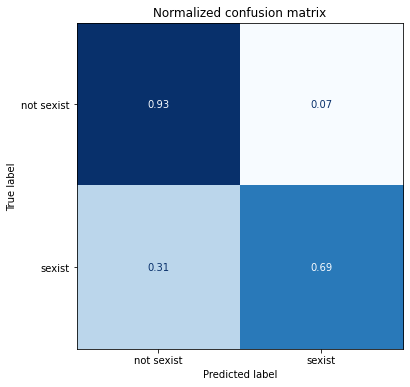

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    

labels = sexist_tokenized["test"].features["labels"].names
plot_confusion_matrix(y_preds, y_test, labels)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1037
           1       0.77      0.69      0.72       363

    accuracy                           0.86      1400
   macro avg       0.83      0.81      0.82      1400
weighted avg       0.86      0.86      0.86      1400



## Testing alternative training data (imbalanced data)

In [24]:
sexist_tokenized.set_format(type = "pandas")
sexist_df = sexist_tokenized["train"][:]
sexist_class0 = sexist_df[sexist_df["labels"]==0]
sexist_class1 = sexist_df[sexist_df["labels"]==1]
count0 = sexist_class0.shape[0]
count1 = sexist_class1.shape[0]
sexist_tokenized.reset_format()
count0,count1

(9565, 3035)

### undersample majority class

In [25]:
sexist_class0_under = sexist_class0.sample(count1)
df_sexist_under = pd.concat([sexist_class0_under, sexist_class1],axis=0)
df_sexist_under.shape

(6070, 7)

In [26]:
from datasets import Dataset
ds_under = Dataset.from_pandas(df_sexist_under)
ds_under = ds_under.shuffle(seed=42)
ds_under

Dataset({
    features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector', 'input_ids', 'attention_mask', '__index_level_0__'],
    num_rows: 6070
})

In [27]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2)
         .to(device))

In [28]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(ds_under) // batch_size
model_name = f"{checkpoint}-sexist_baseline_under"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=hugging, # HuggingFace account necessary
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_under,
                  eval_dataset=sexist_tokenized["test"],
                  tokenizer=tokenizer)

In [29]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
94,0.574100,0.428969,0.817143,0.821989
188,0.415000,0.439868,0.802857,0.812126


TrainOutput(global_step=190, training_loss=0.4930508431635405, metrics={'train_runtime': 100.5042, 'train_samples_per_second': 120.791, 'train_steps_per_second': 1.89, 'total_flos': 292106137559760.0, 'train_loss': 0.4930508431635405, 'epoch': 2.0})

In [30]:
preds_output = trainer.predict(sexist_tokenized["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(sexist_tokenized["test"]["labels"])

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1037
           1       0.58      0.83      0.69       363

    accuracy                           0.80      1400
   macro avg       0.76      0.81      0.77      1400
weighted avg       0.84      0.80      0.81      1400



### oversampling minority class

In [32]:
sexist_class1_over = sexist_class1.sample(count0, replace=True)
df_sexist_over = pd.concat([sexist_class1_over, sexist_class0],axis=0)
df_sexist_over.shape

(19130, 7)

In [33]:
from datasets import Dataset
ds_over = Dataset.from_pandas(df_sexist_over)
ds_over = ds_over.shuffle(seed=42)
ds_over

Dataset({
    features: ['rewire_id', 'text', 'labels', 'label_category', 'label_vector', 'input_ids', 'attention_mask', '__index_level_0__'],
    num_rows: 19130
})

In [34]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2)
         .to(device))

In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(ds_under) // batch_size
model_name = f"{checkpoint}-sexist_baseline_over"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=hugging, # HuggingFace account necessary
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_over,
                  eval_dataset=sexist_tokenized["test"],
                  tokenizer=tokenizer)

In [36]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
94,0.558500,0.388738,0.827857,0.831095
188,0.394400,0.371159,0.832857,0.838652
282,0.342700,0.324313,0.857857,0.859356
376,0.274900,0.382036,0.838571,0.844590
470,0.245000,0.357281,0.853571,0.857028
564,0.219400,0.366910,0.845000,0.849157


TrainOutput(global_step=598, training_loss=0.33287833127688404, metrics={'train_runtime': 318.4281, 'train_samples_per_second': 120.153, 'train_steps_per_second': 1.878, 'total_flos': 920591501073840.0, 'train_loss': 0.33287833127688404, 'epoch': 2.0})

In [37]:
preds_output = trainer.predict(sexist_tokenized["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(sexist_tokenized["test"]["labels"])

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1037
           1       0.67      0.80      0.73       363

    accuracy                           0.84      1400
   macro avg       0.79      0.83      0.81      1400
weighted avg       0.86      0.84      0.85      1400



Hat jetzt mal eher nichts gebracht.